# Exploratory Data Analysis

> *Coming up with features is difficult, time-consuming, requires expert knowledge. 'Applied machine learning' is basically feature engineering*. - Andrew Ng, Founder and CEO of Landing AI

We utilized the framework of exploratory data analysis to explore the structure of the PHEME Rumor Non-Rumor dataset(s) to find potentially useful featurs in a machine learning classifier.

In [1]:
# Import dependencies for this notebook
import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns  # seaborn-0.9.0
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from datetime import datetime
from lib.util import fetch_tweets, to_unix_tmsp

We first aggregated each dataset into one master dataframe work with for the rest of this notebook.

In [2]:
# Specifies the event name and the date of the event
events = {
    "germanwings-crash": datetime(2015, 3, 24),
    "ferguson": datetime(2014, 8, 9),
    "ottawashooting": datetime(2014, 10, 22),
    "charliehebdo": datetime(2015, 1, 7),
    "sydneysiege": datetime(2014, 12, 15)
}

# Combine all PHEME events into one dataframe
tweets = pd.concat([ fetch_tweets(name) for name in events ])
tweets[["is_source_tweet","is_rumor"]] = tweets[["is_source_tweet", "is_rumor"]].astype(bool)

# So what does this data look like anyway?
tweets.describe()

,tweet_length,symbol_count,user_mentions,urls_count,media_count,hashtags_count,retweet_count,favorite_count,mentions_count,is_truncated,...,sentimentscore,Noun,Verb,Adjective,Pronoun,FirstPersonPronoun,SecondPersonPronoun,ThirdPersonPronoun,Adverb,has_url_in_text
count,103212.000000,103212.000000,103212.000000,103212.000000,103212.000000,103212.000000,103212.000000,103212.000000,103212.000000,103212.0,...,103212.000000,103212.000000,103212.000000,103212.000000,103212.000000,103212.000000,103212.000000,103212.000000,103212.0,103212.000000
mean,96.104038,0.000039,1.688282,0.108563,0.091937,0.296438,26.537593,14.766888,1.688282,0.0,...,0.024750,5.756753,2.378328,0.915378,0.665892,0.156871,0.208348,0.400050,0.0,0.165504
std,38.136487,0.006225,1.011805,0.323340,0.289608,0.713807,518.063950,557.239753,1.011805,0.0,...,0.298488,2.896561,1.804487,1.019915,0.955495,0.438892,0.531075,0.726213,0.0,0.371637
min,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,64.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,...,0.000000,4.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,104.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.0,...,0.000000,6.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
75%,133.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.0,...,0.122222,8.000000,4.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.0,0.000000
max,187.000000,1.000000,13.000000,5.000000,2.000000,12.000000,99524.000000,149783.000000,13.000000,0.0,...,1.000000,26.000000,11.000000,8.000000,11.000000,5.000000,11.000000,7.000000,0.0,1.000000


## Violin Plots for Feature Selection

Similar to box-and-whisker plots, a violin plot shows the distribution of quantitive data. Unlike box-and-whisker plots, violin plots show the kernel density estimation of the underlying distribution. 

The chart below is divided by one binary categorical variable and grouped by other categorical variables.

In [3]:
y = tweets['is_rumor']
X = tweets[["sentimentscore", "FirstPersonPronoun", "ThirdPersonPronoun", "hashtags_count", "tweet_length", "user_mentions", "urls_count", "media_count"]]
X = (X - X.mean()) / X.std()  # normalize
data = pd.concat([X, y], axis=1)
data = pd.melt(data, id_vars="is_rumor", var_name="features", value_name="value")

Text(0.5,1,'Distribution of Feature Values (All News Events)')

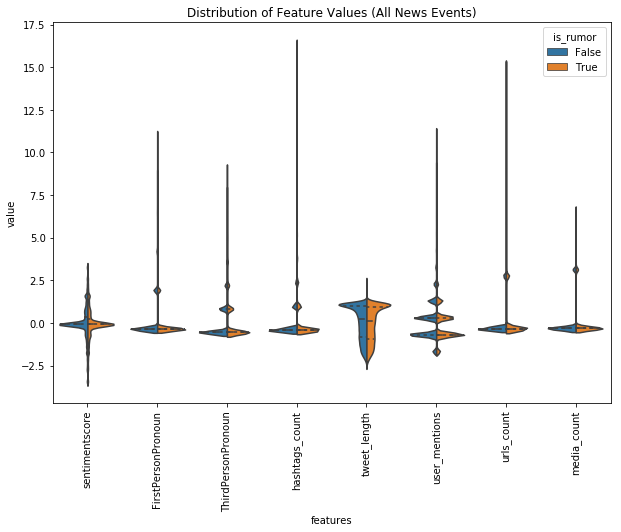

In [22]:
plt.figure(figsize=(10,7))
ax = sns.violinplot(x="features", y="value", hue="is_rumor", data=data, split=True, inner="quart")
plt.xticks(rotation=90)
ax.set_title("Distribution of Feature Values (All News Events)")

Unfortuinately, upon interpreting this figure, it doesn't seem like these feature would be very 

## Ratio of Rumor to Non-Rumor

Since this project is concerned with classifying rumor and non-rumor tweets, we need to know what the proportion of rumor to non-rumor tweets for each event in the PHEME dataset.

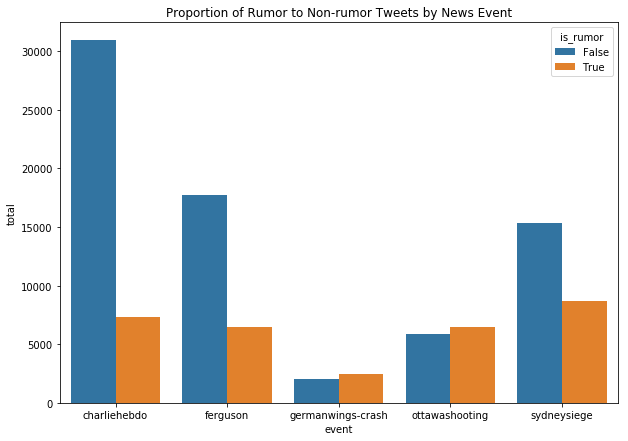

In [21]:
twts_event_rumor = tweets[["event", "tweet_id", "is_rumor"]].groupby(["event", "is_rumor"]).agg(len) \
    .rename(columns={"tweet_id": "total"}).reset_index()
plt.figure(figsize=(10,7))
plt.title("Proportion of Rumor to Non-rumor Tweets by News Event")
ax = sns.barplot(x="event", y="total", hue="is_rumor", data=twts_event_rumor)

## Tweet Frequency Over Time

It seems plausable that immediately after a news event, the number of rumor tweets would be greater than the number of non-rumor tweets as the facts start getting sorted out.

In the Germanwings Crash dataset, the first relevant tweet was recorded on March 24, 2015, which is the date of the actual event. Tweets related to the event were collected for the next eight days.

In [60]:
from IPython.display import IFrame
IFrame("html/gw_beeswarm.html", width="100%", height="650")

If beeswarm plot above won't load, [try this page](https://beta.observablehq.com/@stvkas/twitter-rumors-concerning-the-crash-of-germanwings-flight)

To compare this delay rate across news events, we normalized the data by taking the difference in days between the news event and the tweet creation. This new column called is `delay`.

In [7]:
event_dates = tweets.event.map(lambda x: events[x])
created_date = pd.to_datetime(tweets.created * 1e6).dt.round("D")  # Round to date
tweets["delay"] = created_date - event_dates
tweets.delay = tweets.delay.dt.days  # recast time delta to integer to play nice with plots
tweets.delay.describe()

count    103212.000000
mean          2.229063
std           2.347240
min           0.000000
25%           1.000000
50%           1.000000
75%           3.000000
max          37.000000
Name: delay, dtype: float64

C:\Users\steph\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


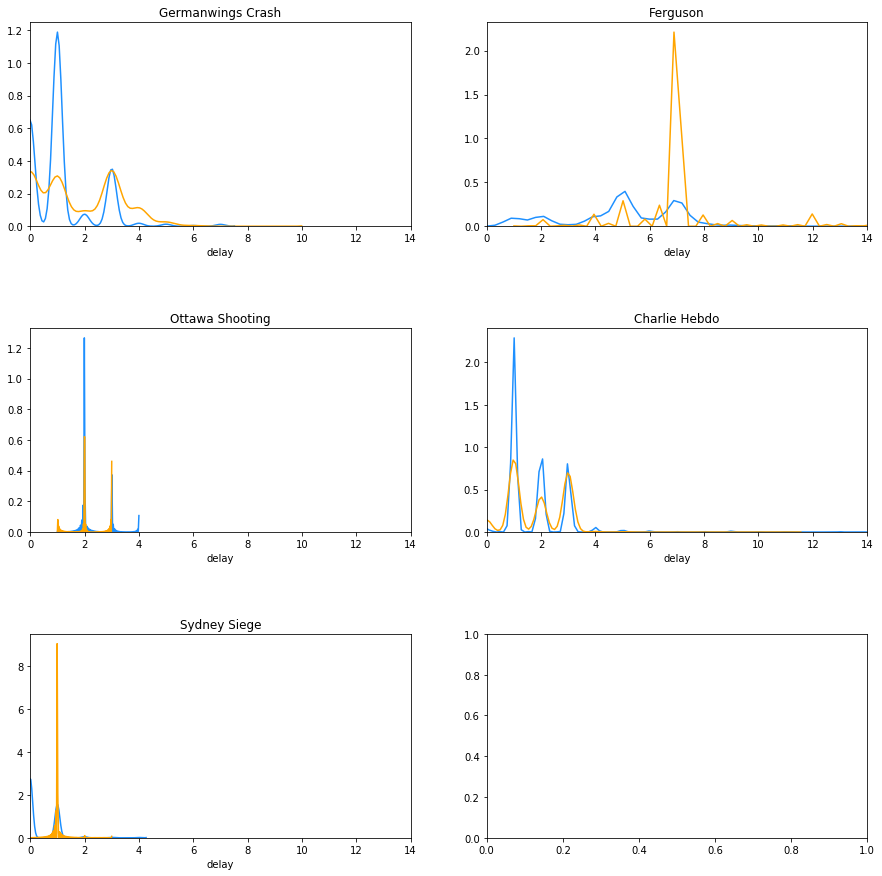

In [8]:
#g = sns.FacetGrid(tweets, col="event", hue="is_rumor", sharey=True, sharex=False)
#g.map(sns.distplot, "delay", hist=False, kde=True)
#g.add_legend()

names = ["Germanwings Crash", "Ferguson", "Ottawa Shooting", "Charlie Hebdo", "Sydney Siege"]
nrows = 3
fig, axs = plt.subplots(ncols=2, nrows=nrows, figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
event_names = [ key for key in events ]

event_index = 0
for row in range(nrows):
    for col in range(2):
        if (event_index < len(names)):
            for k in range(2):
                sns.distplot(tweets[(tweets.event == event_names[event_index]) & (tweets.is_rumor == k)]["delay"],
                             hist=False,
                             color='dodgerblue' if k == 0 else 'orange',
                             ax=axs[row][col])
            axs[row][col].set_title(names[event_index])
            axs[row][col].set_xlim(0,14)
        event_index += 1    
        

In [54]:
def delayPlot(event, name):
    plt.figure(figsize=(10,7))
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)    
    for k in range(2):
        ax = sns.distplot(tweets[(tweets.event == event) & (tweets.is_rumor == k)]["delay"],
                     hist=False,
                     color='dodgerblue' if k == 0 else 'orange')
        ax.set_title(name)
        ax.set_xlim(0,14)

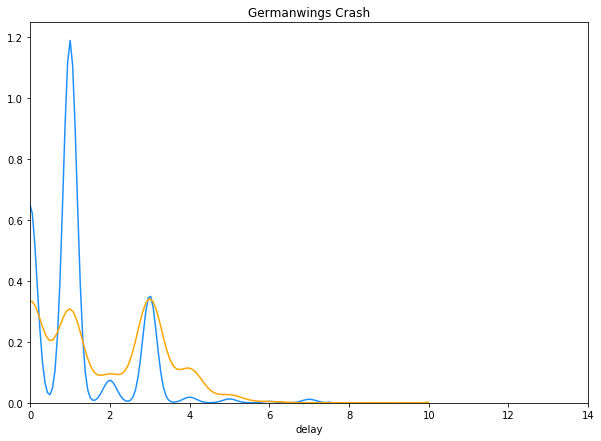

In [55]:
delayPlot("germanwings-crash", "Germanwings Crash")

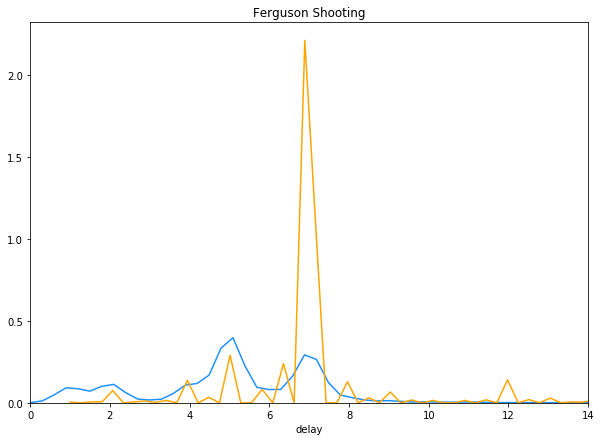

In [56]:
delayPlot("ferguson", "Ferguson Shooting")

## Thread Structures

One reason to use a classifier on tweet threads instead of individual tweets is that the conversation constitutes a graph structure where additional features can be extracted that can't when tweets are considered in isolation. For each event, most of the tweets are replies to other tweets.

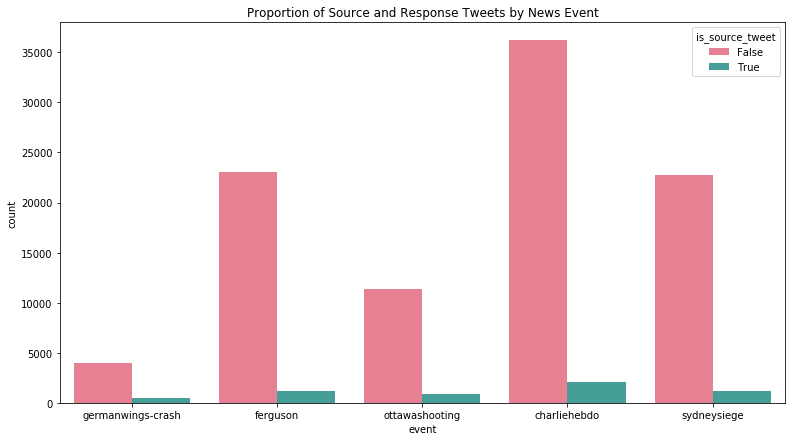

In [26]:
plt.figure(figsize=(13,7))
plt.title("Proportion of Source and Response Tweets by News Event")
ax = sns.countplot(x="event", hue="is_source_tweet", data=tweets, palette="husl")

As the histogram above shows, there are many more tweets in reply to a tweet than other source tweet. This may mean that there may be some interesting features to exploit in a machine learning classifier based on the graph structure of these Twitter conversations.

## Exploring the Conversational Network Structure

Tweets in the PHEME dataset are organized into threads, proxies for conversations threads. When one tweet replies to another, it constitutes a thread. Since the vast majority of tweets in this dataset are replies to other tweets, we examined the distribution of *thread length*, the number of individual tweets in a thread. 

The variable `thread_lengths` contains the  groups tweet data by event and thread, then counts the number of tweets per thread-event group. Each thread should be unique, but grouping by event first makes the code more understandable.

In [27]:
thread_lengths = tweets.groupby(["event", "thread"]) \
    .agg({ "tweet_id": len, "is_rumor": max }) \
    .reset_index() \
    .rename(columns={"tweet_id": "thread_length"})[["event", "thread", "is_rumor", "thread_length"]]

thread_lengths.head()

,event,thread,is_rumor,thread_length
0,charliehebdo,552783238415265792,True,10
1,charliehebdo,552783667052167168,True,8
2,charliehebdo,552783745565347840,True,6
3,charliehebdo,552784168849907712,True,14
4,charliehebdo,552784526955806720,True,17


In [28]:
thread_lengths.groupby("event").describe()

thread_length                                              \
                          count       mean        std  min  25%   50%   75%   
event                                                                         
charliehebdo             2079.0  18.406926  19.962353  1.0  8.0  15.0  22.0   
ferguson                 1143.0  21.150481  26.272486  1.0  7.0  16.0  22.0   
germanwings-crash         469.0   9.571429   9.470699  1.0  3.0   6.0  15.0   
ottawashooting            890.0  13.802247  11.884767  1.0  6.0  11.0  19.0   
sydneysiege              1221.0  19.652744  20.139285  1.0  9.0  17.0  22.0   

                          
                     max  
event                     
charliehebdo       346.0  
ferguson           289.0  
germanwings-crash   77.0  
ottawashooting     108.0  
sydneysiege        342.0

Text(0.5,1,'Thread Length by Event and Rumor')

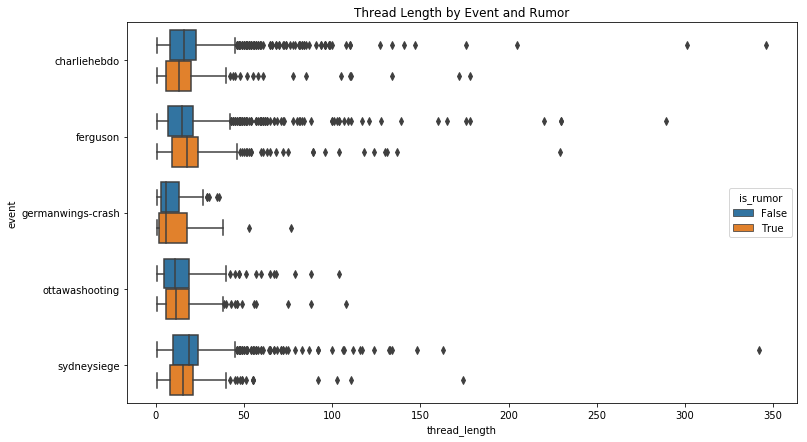

In [30]:
fig, axes = plt.subplots(figsize=(12,7))
ax = sns.boxplot(y="event", 
            x="thread_length", 
            hue="is_rumor", 
            data = thread_lengths)

ax.set_title("Thread Length by Event and Rumor")

## Combining Structure and Rumor


In [31]:
def graph_connections(edgelist, title):
    colorPal = {"rumor": "orange", "nonrumor": "dodgerblue"}
    G = nx.from_pandas_edgelist(edgelist, "user_id", "in_reply_user")
    pos = nx.layout.spring_layout(G)

    rumor_to_color = lambda rumor : colorPal['rumor'] if rumor == True else colorPal['nonrumor']
    node_colors = [rumor_to_color(val) for val in edgelist['is_rumor']]
    plt.figure(figsize=(10,7))

    nodes = nx.draw_networkx_nodes(G, pos,
                               node_color=node_colors,
                               node_size=10)

    edges = nx.draw_networkx_edges(G, pos,
                                arrowsize=30, 
                                width=1)

    ax = plt.gca()
    ax.set_axis_off()
    ax.set_title(title)

    legend_elements = [
        Line2D([0],[0], marker='o', markerfacecolor=colorPal['rumor'], label="Rumor", color='slategray', markersize=10),
        Line2D([0],[0], marker='o', markerfacecolor=colorPal['nonrumor'], label="Non-Rumor", color='slategray', markersize=10)    
    ]

    ax.legend(handles=legend_elements)
    plt.show()

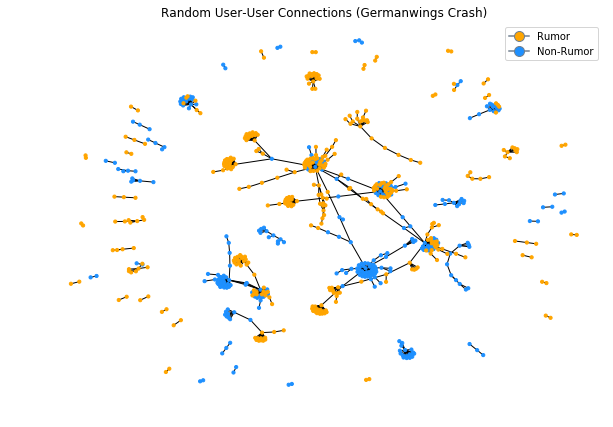

In [32]:
random_threads = list(tweets[tweets.event == "germanwings-crash"][["thread"]].sample(50, random_state=2).thread)
random_connections = tweets[tweets.thread.isin(random_threads)]
graph_connections(random_connections, "Random User-User Connections (Germanwings Crash)")

We start to see some interesting patterns in the user-to-user response network in a thread. One of the most interesting interpretations is that mix of orange rumor and dodger blue non-rumor in some of the components. Tweet threads are pre-classified into rumor and non-rumor; however, when looking at user-user networks we see rumors who have engaged in rumor behavior interacting with users who have engaged in non-rumor behavior. Thus, transcending Twitter threads.

In [34]:
largest_thread = tweets[["thread", "user_id", "event"]] \
    .groupby("thread") \
    .agg({"user_id" : pd.Series.nunique, "event" : max}) \
    .sort_values("user_id", ascending=False) \
    [0:1]

largest_thread

,user_id,event
thread,,
499695918547861504,125,ferguson


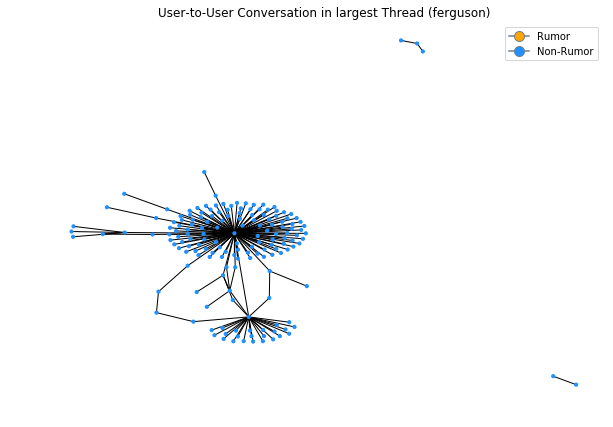

In [36]:
dense_connections = tweets[tweets.thread.isin(list(largest_thread.index))]
graph_connections(dense_connections, "User-to-User Conversation in largest Thread (%s)" % largest_thread.event[0])

This visualization lends itself to two possibly interesting features:

1. The number of components per thread.
2. The diameter of the largest component.
